# Notebook on growth in Europe

I download GDP per capita, CPI and the GDP deflator from Eurostat and plot real GDP per capita for a few countries.

In [1]:
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fredapi import Fred
fred = Fred(api_key='YOUR_API_KEY_HERE') #Get a free API key from https://fred.stlouisfed.org/docs/api/api_key.html

plt.style.use("fivethirtyeight")

## Real GDP growth per capita

In [2]:
# Europe
df1 = eurostat.get_data_df("nama_10_pc")
df2 = eurostat.get_data_df("prc_hicp_aind")
df3 = eurostat.get_data_df("nama_10_gdp")

# Norway
df_nor_pop = pd.read_csv("https://www.ssb.no/statbank/sq/10102202", sep =";", skiprows=1, encoding='latin1')
df_nor = pd.read_csv("https://www.ssb.no/en/statbank/sq/10102130", sep =";", skiprows=1)

# US
# Define the FRED series ID for US Real GDP
series_ids = ['A939RC0Q052SBEA', 'GDPDEF', 'CPIAUCSL']  # This is the series ID for US nominal GDP per capita
# Download the data from FRED
df_us = pd.DataFrame([fred.get_series(series_id) for series_id in series_ids]).transpose()


### Europe
    

In [3]:
def massage_df(df):
    df.columns = df.iloc[3]
    df = df.iloc[4:]
    df.index = pd.to_datetime(df.index)
    df = df.astype(float).apply(np.log)
    df.index = df.index.to_period('Y').to_timestamp('Y')
    return df

df_gdp_pc = df1[(df1['unit'] == 'CP_NAC_HAB')*(df1['na_item']=='B1GQ')].transpose()
df_gdp_pc = massage_df(df_gdp_pc)

df_cpi = df2[(df2['unit'] == 'INX_A_AVG')*(df2['coicop']=='CP00')].transpose()
df_cpi = massage_df(df_cpi)

df_gdp_def = df3[(df3['unit'] == 'PD15_NAC')*(df3['na_item']=='B1GQ')].transpose()
df_gdp_def = massage_df(df_gdp_def)

df_real_gdp1 = (df_gdp_pc-df_gdp_def)
df_real_gdp2 = (df_gdp_pc-df_cpi)

df_real_gdp2.drop(columns = ['US'], inplace=True)


### Norway

In [4]:
# Convert 'år' column to datetime
df_nor_pop['år'] = pd.to_datetime(df_nor_pop['år'].astype(str), format='%Y')

# Set 'år' as the index
df_nor_pop.set_index('år', inplace=True)

# Rename the index
df_nor_pop.index.name = 'year'
df_nor_pop.index = df_nor_pop.index.to_period('Y').to_timestamp('Y')
df_nor_pop.columns = ['Population']

def parse_quarter(date_string):
    year, quarter = date_string.split('K')
    month = (int(quarter) - 1) * 3 + 1  # Convert quarter to month (Q1->1, Q2->4, Q3->7, Q4->10)
    return f"{year}-{month:02d}-01"

df_nor['quarter'] = pd.to_datetime(df_nor['quarter'].apply(parse_quarter))
df_nor.set_index("quarter", inplace=True)
df_nor.columns = ["GDP", "GDP deflator", "GDP mainland", "GDP mainland deflator"]

# Aggregate to annual data
df_nor = df_nor.resample('Y').agg({
    'GDP': 'sum',
    'GDP deflator': 'mean',
    'GDP mainland': 'sum',
    'GDP mainland deflator': 'mean'
})

df_nor['Population'] = df_nor_pop['Population']

# Drop the last observation
df_nor = df_nor.iloc[:-1]
df_nor.index = df_nor.index.to_period('Y').to_timestamp('Y')

df_nor_rgdp1 = pd.DataFrame([np.log(df_nor['GDP']/df_nor['GDP deflator'])-np.log(df_nor['Population']), np.log(df_nor['GDP mainland']/df_nor['GDP mainland deflator'])-np.log(df_nor['Population'])]).transpose()
df_nor_rgdp2 = pd.DataFrame([np.log(df_nor['GDP'])-df_cpi['NO']-np.log(df_nor['Population']), np.log(df_nor['GDP mainland'])-df_cpi['NO']-np.log(df_nor['Population'])]).transpose()

df_nor_rgdp1.columns = ['NO SSB', 'NOf']
df_nor_rgdp2.columns = ['NO SSB', 'NOf']


/var/folders/s0/3g1gb_9s56x9hxnb2d1npjc80000gn/T/ipykernel_57423/3191115566.py:22: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_nor = df_nor.resample('Y').agg({


### US

In [5]:
df_us.columns = ['GDP pc', 'GDP deflator', 'CPI']

df_us = df_us.resample('Y').agg({
    'GDP pc': 'sum',
    'GDP deflator': 'mean',
    'CPI': 'mean'
})

df_us = df_us.iloc[:-1]

df_us = np.log(df_us)

df_us_rgdp = pd.DataFrame([df_us['GDP pc']-df_us['GDP deflator'], df_us['GDP pc']-df_cpi['US']]).transpose()
df_us_rgdp.columns = ["US (GDP def)", "US (CPI)"]


/var/folders/s0/3g1gb_9s56x9hxnb2d1npjc80000gn/T/ipykernel_57423/2031372275.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_us = df_us.resample('Y').agg({


### Final data sets

In [6]:
# Combine the two datasets with the same index using pd.concat
combined_df1 = pd.concat([df_real_gdp1, df_nor_rgdp1, df_us_rgdp['US (GDP def)']], axis=1)
combined_df2 = pd.concat([df_real_gdp2, df_nor_rgdp2, df_us_rgdp['US (CPI)']], axis=1)

combined_df1.rename(columns = {'US (GDP def)':'US', 'EU27_2020':'EU27'}, inplace=True)
combined_df2.rename(columns = {'US (CPI)':'US', 'EU27_2020':'EU27'}, inplace=True)

for df in [combined_df1, combined_df2]:
    df['0%'] = 0.00*np.arange(df.shape[0])
    df['1%'] = 0.01*np.arange(df.shape[0])
    df['2%'] = 0.02*np.arange(df.shape[0])
    df['3%'] = 0.03*np.arange(df.shape[0])
    df['4%'] = 0.04*np.arange(df.shape[0])
combined_df1 = combined_df1.subtract(np.array(combined_df1.loc[combined_df1.index == pd.to_datetime('2004-12-31')]), axis = 1)
combined_df2 = combined_df2.subtract(np.array(combined_df2.loc[combined_df2.index == pd.to_datetime('2004-12-31')]), axis = 1)


### Graphs

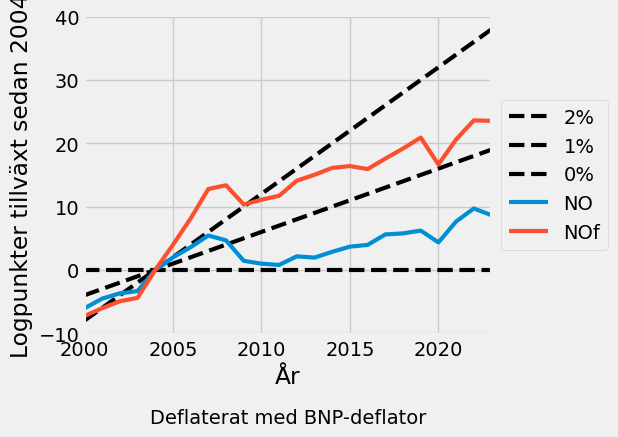

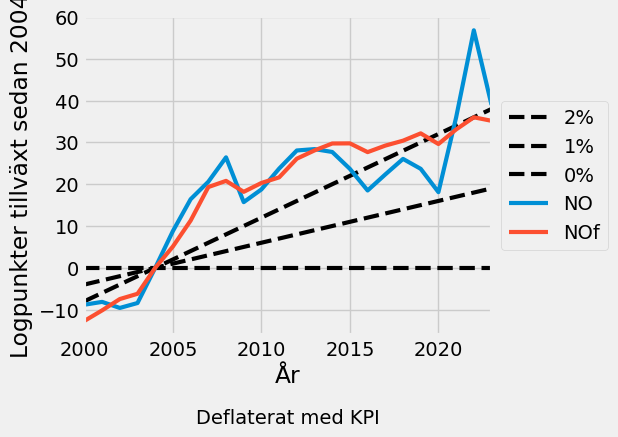

In [7]:
subset = ['2%', '1%', '0%', 'NO', 'NOf']

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')
    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    plt.tight_layout()

    plt.savefig('figures/GDP_growth'+str(count)+'_NO.pdf')
    plt.show()
    count += 1

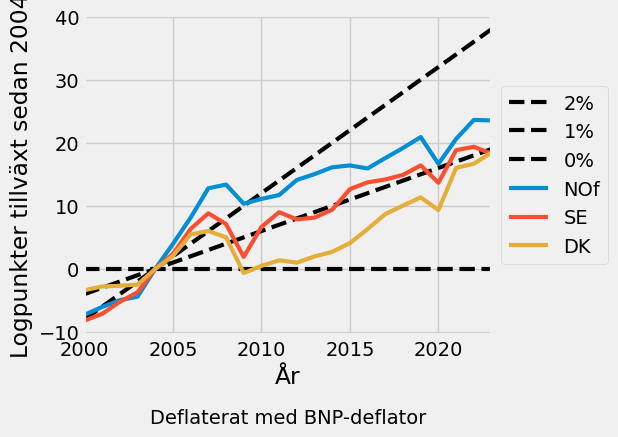

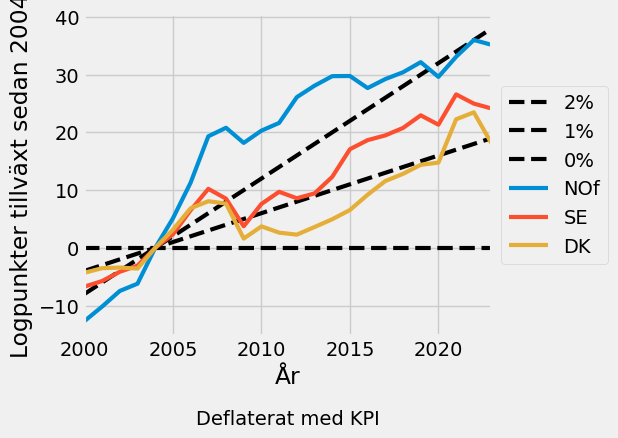

In [8]:
subset = ['2%', '1%', '0%', 'NOf', 'SE', 'DK']

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_Scandinavia.pdf')
    plt.show()
    count += 1


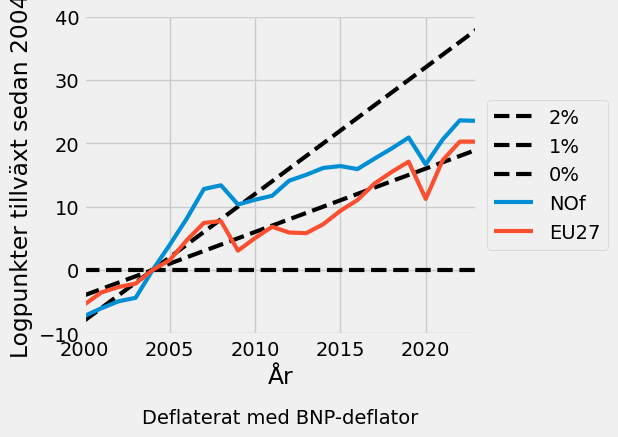

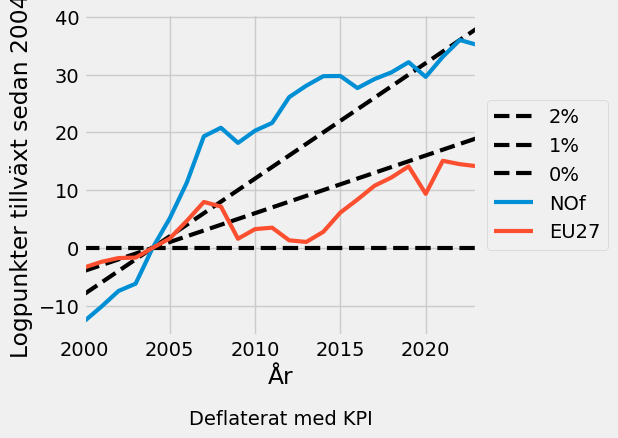

In [9]:
subset = ['2%', '1%', '0%', 'NOf','EU27']

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_Europe_Norway.pdf')
    plt.show()
    count += 1


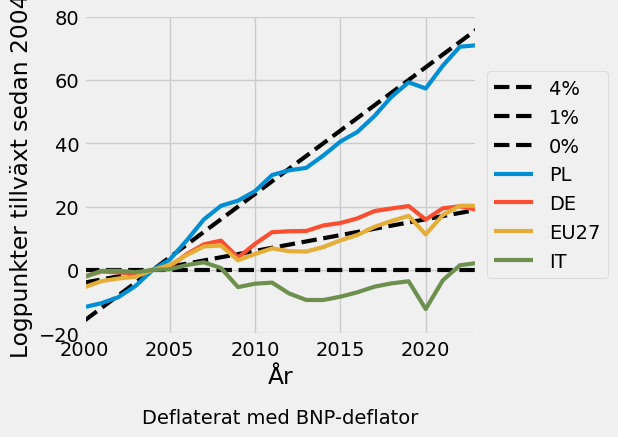

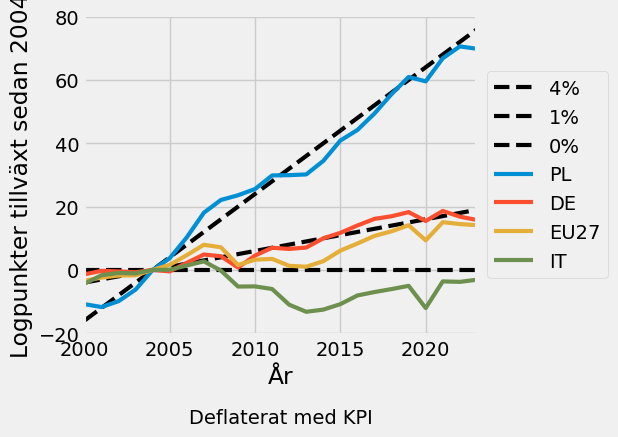

In [10]:
subset = ['4%', '1%', '0%' , 'PL', 'DE', 'EU27', 'IT'] #'EU27_2020', 'US'] # 'NO', 'NO fastland', 'IT',

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_Europe.pdf')
    plt.show()
    count += 1

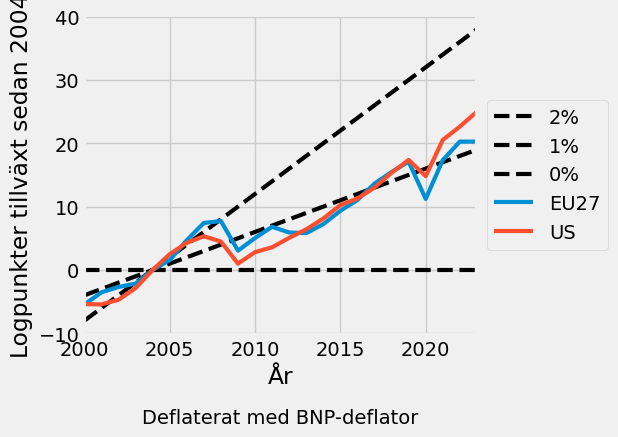

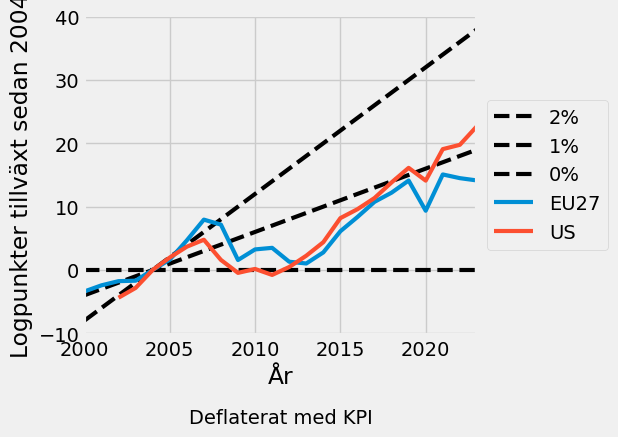

In [11]:
subset = ['2%', '1%', '0%', 'EU27', 'US']

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_world.pdf')
    plt.show()
    count += 1


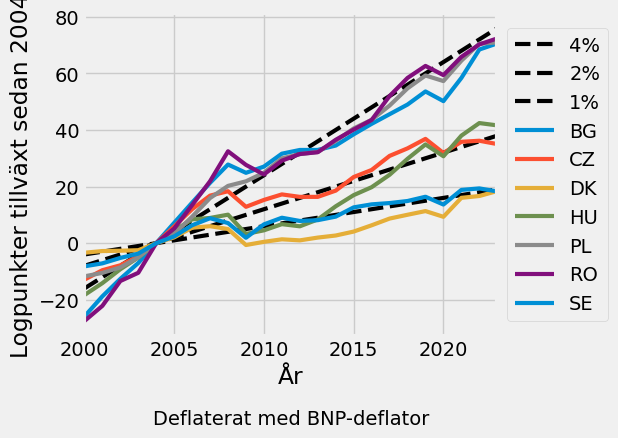

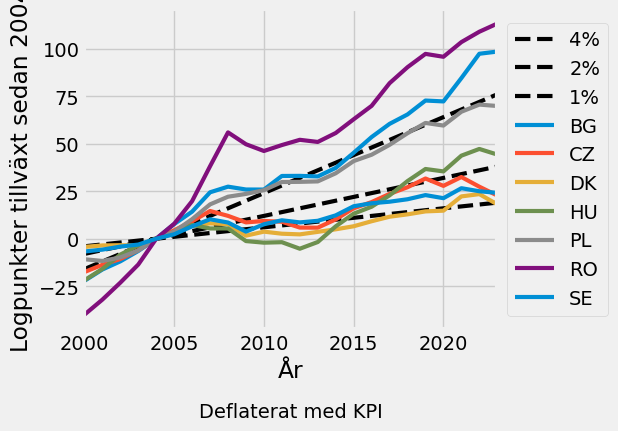

In [12]:
subset = ['4%', '2%', '1%' , 'BG', 'CZ', 'DK','HU', 'PL', 'RO', 'SE'] #'EU27_2020', 'US'] # 'NO', 'NO fastland', 'IT',

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--', 'k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_Europe_noEA.pdf')
    plt.show()
    count += 1

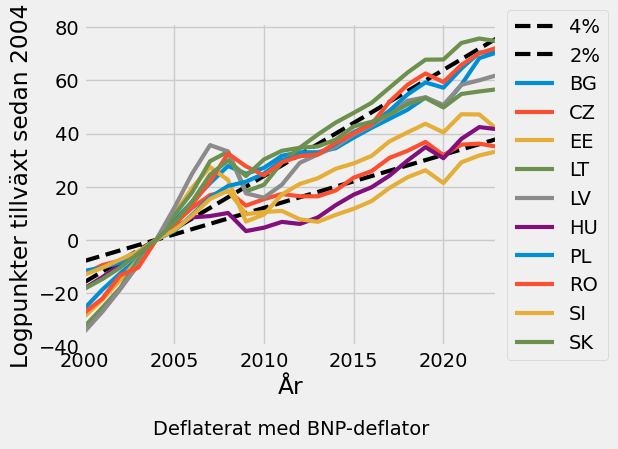

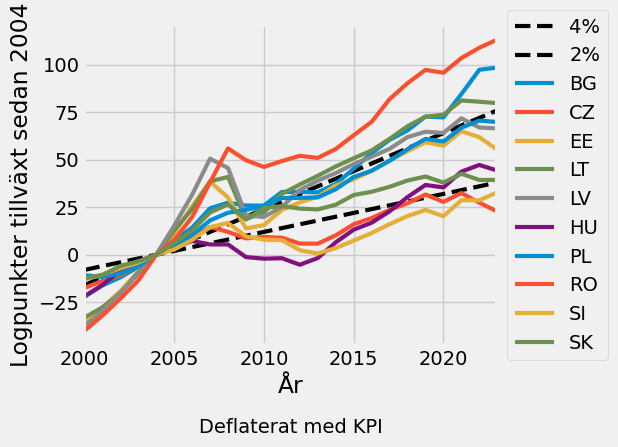

In [13]:
subset = ['4%', '2%', 'BG', 'CZ', 'EE', 'LT', 'LV', 'HU', 'PL', 'RO', 'SI', 'SK'] #'EU27_2020', 'US'] # 'NO', 'NO fastland', 'IT',

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_Europe_former_communist.pdf')
    plt.show()
    count += 1

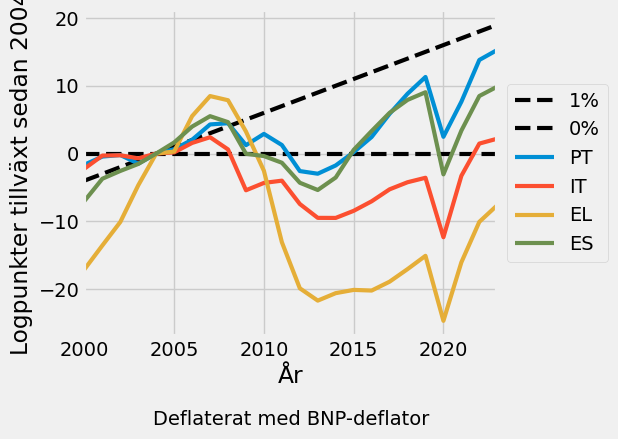

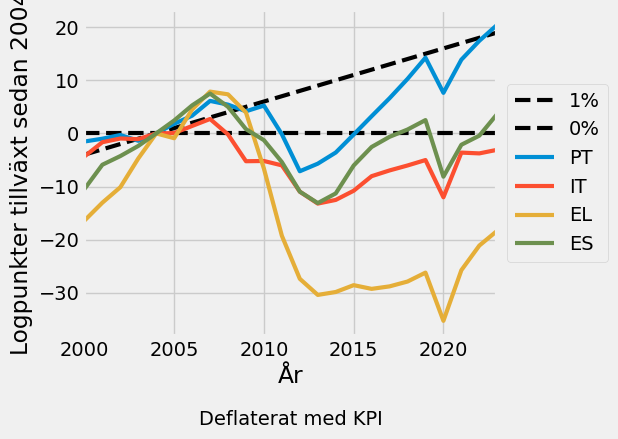

In [14]:
subset = ['1%', '0%', 'PT', 'IT', 'EL', 'ES'] #'EU27_2020', 'US'] # 'NO', 'NO fastland', 'IT',

count = 0
for df in [combined_df1, combined_df2]:

    df.index.name = "År"
    df.columns.name = "Land"

    (100*df[subset].loc[df.index > pd.to_datetime('2000-01-01')]).plot(
        lw = 3, style=['k--','k--']).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

    plt.ylabel('Logpunkter tillväxt sedan 2004')

    if count == 0:
        plt.title('Deflaterat med BNP-deflator', y=-0.3, fontsize = 14)
    else:
        plt.title('Deflaterat med KPI', y=-0.3, fontsize = 14)
    
    plt.tight_layout()
    plt.savefig('figures/GDP_growth'+str(count)+'_PIGS.pdf')
    plt.show()
    count += 1

## Export data sets

In [15]:
#export data sets
combined_df1.to_csv('data/GDP_growth_data_gdp_deflator.csv')
combined_df2.to_csv('data/GDP_growth_data_cpi.csv')

#export to excel
with pd.ExcelWriter('data/GDP_growth_data.xlsx') as writer:
    combined_df1.to_excel(writer, sheet_name='Deflated with GDP deflator')
    combined_df2.to_excel(writer, sheet_name='Deflated with CPI')